In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from copy import copy

In [2]:
classes = ['Food','Culture','Nature','Sight Seeing','Museum','Store']

In [15]:
# toy model
import random

n_loc = 50
my_class = []
test_loc_lng = np.random.rand(n_loc)
test_loc_lat = np.random.rand(n_loc)
loc = []
user_weights = []
rating = []
for k in classes:
    user_weights.append(np.random.uniform(0.,1.))
for i in range(50):
    my_class.append(random.choice(classes))
    rating.append(np.random.uniform(3,5))

In [16]:
df = pd.DataFrame()
df['type'] = my_class
df['lng'] = test_loc_lng
df['lat'] = test_loc_lat
df['rating'] = rating

In [5]:
df.head(10)

,type,lng,lat,rating
0,Food,40.819688,-73.915091,3.835332
1,Nature,40.815421,-73.941761,3.652499
2,Sight Seeing,40.764198,-73.910785,4.022984
3,Museum,40.768790,-73.953285,3.633267
4,Store,40.743613,-73.952950,3.967311
5,Nature,40.745313,-73.977998,3.490116
6,Nature,40.662713,-73.993793,4.038988
7,Culture,40.703761,-73.946101,4.682747
8,Culture,40.713620,-147.829572,4.221437
9,Store,40.725212,-73.809179,4.939418


In [6]:
df_food = df[df['type'] == 'Food']

In [7]:
df_food

,type,lng,lat,rating
0,Food,40.819688,-73.915091,3.835332


In [17]:
user_opt = {'Food': True,'Culture': 0.1,'Nature':0.25,'Sight Seeing':0.15,'Museum':0.1,'Store':0.4}

In [9]:
user_opt

{'Food': True,
 'Culture': 0.1,
 'Nature': 0.25,
 'Sight Seeing': 0.15,
 'Museum': 0.1,
 'Store': 0.4}

In [18]:
loc_df = df[df.type!='Food']
food_df = df[df.type=='Food']

In [23]:
food_df.iloc[[1,4,3]]

,type,lng,lat,rating
3,Food,0.869282,0.653531,3.432719
34,Food,0.961903,0.337136,4.274619
28,Food,0.831365,0.716850,3.894910


In [87]:
class route:
    
    part1 = []
    part2 = []
    
    food = []
    
    def get_route_no_dist(self):
        return pd.concat([self.part1,self.food,self.part2])
    
    def compute_distances(self,startpoint):
        r = self.get_route_no_dist()
        
        x = r.lng.values
        y = r.lat.values
        distances = []
        for i in range(len(r)):
            if i==0:
                dist = np.sqrt( (x[i]-startpoint[0])**2+(y[i]-startpoint[1])**2 )
            else:
                dist = np.sqrt( (x[i]-x[i-1])**2+(y[i]-y[i-1])**2 )
            distances.append(dist)
        return distances
    
    def get_route(self,startpoint):
        r = self.get_route_no_dist()
        distances = self.compute_distances(startpoint)
        r['distances'] = distances
        return r
    def route_score(self, startpoint, class_weights):
        score = 0
        r = self.get_route(startpoint)
        
        for i in range(len(r)):
            
            c_weight = float(class_weights[r.iloc[i].type])
            
            score_i = ((r.iloc[i].rating)/(r.iloc[i].distances))*c_weight
            score+=score_i
            
        return score
        
def generate_route(locations,add_food,food_locations):
    
    r = route()
    
    part1_len = np.random.randint(1,3)
    part2_len = np.random.randint(1,3)
    
    track = np.random.choice(range(len(locations)),part1_len+part2_len,replace=False)
    
    r.part1 = locations.iloc[ track[:part1_len] ]
    r.part2 = locations.iloc[ track[part1_len:] ]
    
    if add_food:
        food_idx = np.random.choice(range(len(food_locations)))
        r.food = food_locations.iloc[[food_idx]]
    
    return r

def generate_routes(n, locations,add_food,food_locations):
    
    routes = []
    for i in range(n):
        routes.append( generate_route(locations,add_food,food_locations) )
    return routes

def pick_1outof2(s1,s2):
    
    rand_n = np.random.rand()
    
    thresh = s1/(s1+s2)
    
    if reand_n > thresh:
        return 1
    else:
        return 0

def create_child(r1,score1,r2,score2):
    
    child = route()
    
    parents = [r1,r2]
    
    is_food = len(r1.food)
    if is_food:
        which_food = pick_1outof2(score1,score2)
        child.food = parents[which_food].food
    
    
    part1_parent = pick_1outof2(score1,score2)
    part2_parent = pick_1outof2(score1,score2)
    
    child.part1 = parents[part1_parent].part1
    child.part2 = parents[part2_parent].part2
    
    return child
    
def check_child(child):
    start = [-1,1]
    r = child.get_route(start)
    if 0.0 in r.distances.values:
        return False
    else:
        return True
    
def mate_parents(r_list,startpoint,class_weights):
    
    children = []
    
    alpha = r_list[0]
    score1 = alpha.route_score(startpoint,class_weights)
    
    for par_i in range(1,len(r_list)):
        beta = r_list[par_i]
        score2 = beta.route_score(startpoint,class_weights)
        
        child = create_child(alpha,score1,beta,score2)
        if check_child(child):
            children.append(child)
        else:
            child = create_child(alpha,score1,beta,score2)
            if check_child(child):
                children.append(child)
    return children
    

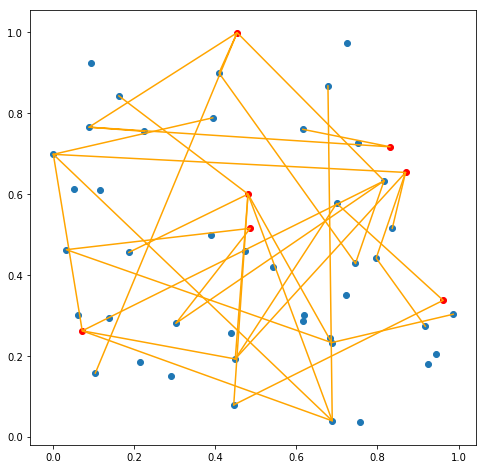

In [88]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,8))

start = [0.9,0.5]

for i in range(12):
    r = generate_route(loc_df,True,food_df)
    #print(r)
    x = r.get_route(start).lng
    y = r.get_route(start).lat
    
    ax.plot(x,y,c='orange')
    


ax.scatter(loc_df.lng,loc_df.lat)
ax.scatter(food_df.lng,food_df.lat,c='r')

plt.show()

In [ ]:
def get_best_route(startingpoint, loc_df, food_df, do_food, class_weights):
    n_in_gen = 10
    n_top = 5
    n_generations = 10
    
    current_gen = generate_routes(n_in_gen, loc_df, do_food ,food_df)
    
    for gen_i in range(n_generations):
        scores = [ x.route_score(startingpoint, class_weights) for x in current_gen ]
        topscores = sorted(zip(scores,current_gen))[-n_top:]
        best_ones = [x for _,x in topscores]
        
        children = mate_parents(best_ones,startpoint,class_weights)
        n_children = len(children)
        
        new_blood = []
        if n_in_gen-n_top-n_children > 0:
            new_blood = generate_routes(n_in_gen-n_top-n_children, loc_df, do_food ,food_df)
        current_gen = best_ones+childre+new_blood
    
    scores = [ x.route_score(startingpoint, class_weights) for x in current_gen ]
    topscores = sorted(zip(scores,current_gen))[-1]
    best_one = topscores[1]
    
    return best_one

In [84]:
a = True

In [85]:
float(a)

1.0

In [92]:
0 in np.array([0.0,0.1,0.8])

True